In this notebook we evaluate the correlation function multipoles for BOSS DR12 data using Corrfunc.

Data:
https://data.sdss.org/sas/dr12/boss/lss/

In [1]:
from astropy.io import fits
import sys
sys.path.append('../2PCF/Functions')

#bibliotecas necessárias para a função cf_smu
import numpy as np
import pandas as pd
import time 
from Corrfunc.mocks.DDsmu_mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from astropy.cosmology import FlatLambdaCDM as FLCDM


import matplotlib.pyplot as plt
import cf_tools as cf

https://github.com/xiaodongli1986/pythonlib

https://github.com/xiaodongli1986/2PCF_AP

In [2]:
# https://arxiv.org/pdf/1607.03148.pdf

c  = 299792458/1000
zmin, zmax = 0.1, 0.6

In [3]:
# https://docs.astropy.org/en/stable/io/fits/index.html

# Galaxies

hdul = fits.open("galaxy_DR12v5_CMASSLOWZE2_North.fits")
hdul.verify('fix')
data = hdul[1].data
# print(data.columns)
hdul.close()

ra0  = data['RA']
dec0 = data['DEC']
z0   = data['Z']


sel = (z0 > zmin) & (z0 < zmax)
ra, dec, z = ra0[sel], dec0[sel], z0[sel]

In [4]:
# randoms
with fits.open('random0_DR12v5_CMASSLOWZE2_North.fits') as hdul:
    hdul.verify('fix')
    data2 = hdul[1].data
    
ra0  = data2['RA']
dec0 = data2['DEC']
z0   = data2['Z']

sel = (z0 > zmin) & (z0 < zmax)
rar0, decr0, zr0 = ra0[sel], dec0[sel], z0[sel]

# takes less randoms so it can run in my computer
mp      = 5
size0   = rar0.size
newsize = ra.size * mp

selec = np.random.choice(range(size0), newsize)

rar, decr, zr = rar0[selec], decr0[selec], zr0[selec] 

In [5]:
radecr1 = np.array([ra, dec, c*z]).T
radecr2 = np.array([rar, decr, c*zr]).T

In [6]:
def make_logbins(rmin, rmax, nbins):
    return np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)

def cf_smu(radecr1, radecr2, binfile, nthreads, mu_max = 1, nmu_bins = 100):
    ra, dec, cz = radecr1[:,0], radecr1[:,1], radecr1[:,2]
    rar, decr, czr = radecr2[:,0], radecr2[:,1], radecr2[:,2]
    N, Nr = ra.size, rar.size
    nbins = binfile.size - 1
    
    is_com    = False
    cosmology = 1

    # DD
    autocorr=1
    time0=time.time()
    resultsDD = DDsmu_mocks(autocorr = autocorr, cosmology = cosmology, nthreads = nthreads, mu_max = mu_max,
                           nmu_bins = nmu_bins, binfile = binfile, 
                           RA1 = ra, DEC1 = dec, CZ1 = cz, is_comoving_dist = is_com)
    DD_counts = np.array([], dtype=(np.float, 2))
    for r in resultsDD:
        DD_counts = np.vstack((DD_counts,np.array([r['mumax'],r['npairs']])))
    DD_time = time.time()- time0
    print("\t Tempo DD = ",DD_time,"s")

    # RR
    autocorr=1
    time0=time.time()
    resultsRR = DDsmu_mocks(autocorr = autocorr, cosmology = cosmology, nthreads = nthreads, mu_max = mu_max,
                           nmu_bins = nmu_bins, binfile = binfile, 
                           RA1 = rar, DEC1 = decr, CZ1 = czr, is_comoving_dist = is_com)
    RR_counts=np.array([], dtype=(np.float, 2))
    for r in resultsRR:
        RR_counts=np.vstack((RR_counts,np.array([r['mumax'],r['npairs']])))
    RR_time = time.time()- time0
    print("\t Tempo RR = ",RR_time,"s")

    # DR
    time0=time.time()
    autocorr=0 
    resultsDR=DDsmu_mocks(autocorr, cosmology, nthreads, mu_max, nmu_bins, binfile, ra, dec, cz, RA2=rar, DEC2=decr,CZ2=czr,is_comoving_dist = is_com)
    DR_counts=np.array([], dtype=(np.float, 2))
    for r in resultsDR:
        DR_counts=np.vstack((DR_counts,np.array([r['mumax'],r['npairs']])))
    DR_time = time.time()- time0
    print("\t Tempo DR = ",DR_time,"s")
    
    # cf
    cf=np.array([],dtype=(np.float, nbins))
    #print("i","|","cftemp","|","cf")
    for i in range(nmu_bins):
        cftemp = convert_3d_counts_to_cf(N, N, Nr, Nr,DD_counts[i::nmu_bins,1], DR_counts[i::nmu_bins,1],DR_counts[i::nmu_bins,1], RR_counts[i::nmu_bins,1])
        #print(i,'\t',cftemp[:5])
        #print(i,"|",np.shape(cftemp),'|',np.shape(cf))
        cf = np.vstack((cf,np.array(cftemp)))

    mubin = DD_counts[:nmu_bins,0]
    
    return mubin, cf

In [7]:
binfile = make_logbins(40, 160, 24)

mubin, cfunc = cf_smu(radecr1, radecr2, binfile, 6)

/tmp/ipykernel_88022/768751874.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  DD_counts = np.array([], dtype=(np.float, 2))


	 Tempo DD =  4.158465147018433 s


/tmp/ipykernel_88022/768751874.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  RR_counts=np.array([], dtype=(np.float, 2))


	 Tempo RR =  83.23516702651978 s
	 Tempo DR =  38.63743042945862 s


/tmp/ipykernel_88022/768751874.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  DR_counts=np.array([], dtype=(np.float, 2))
/tmp/ipykernel_88022/768751874.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cf=np.array([],dtype=(np.float, nbins))


In [9]:
# dfcf = pd.DataFrame(cfunc, columns = None)
# dfcf.to_csv('correfunc_5x_z0106.csv', index = False)
# cf1 = pd.read_csv('correfunc2.csv').to_numpy()

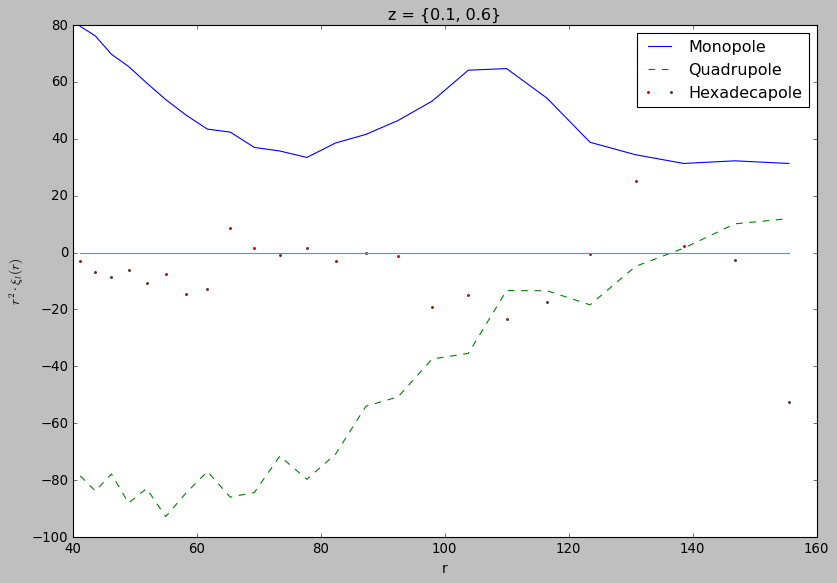

In [33]:
r = binfile
rmin, rmax = 40, 160
x=(r[:-1]+r[1:])/2
mubincenter = (mubin[:-1] + mubin[1:])/2
xi_0, xi_2, xi_4 = cf.multipoles_trapz(mubin, cfunc)

#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')
plot = 'x2xi'
# plot = 'xi'

fig, ax = plt.subplots(figsize=(12,8))

plt.xlim(rmin,rmax)
if plot == 'x2xi':
    ax.plot(x,x**2*xi_0,'-',x,x**2*xi_2,'--',x,x**2*xi_4,'o',markersize=1.9)
    plt.xlabel("r")
    plt.ylabel(r"$r^2\cdot \xi_l(r)$")

elif plot == 'xi':
    ax.plot(x,xi_0,'-',x,xi_2,'--',x,xi_4,'o',markersize=1.9)
    plt.xlabel("r")
    plt.ylabel(r"$\xi_l(r)$")

ax.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')

hor = [0]*len(x) 
ax.plot(x,hor)

ax.set_title('z = {' + str(zmin) + ', ' + str(zmax) + '}')

plt.show()

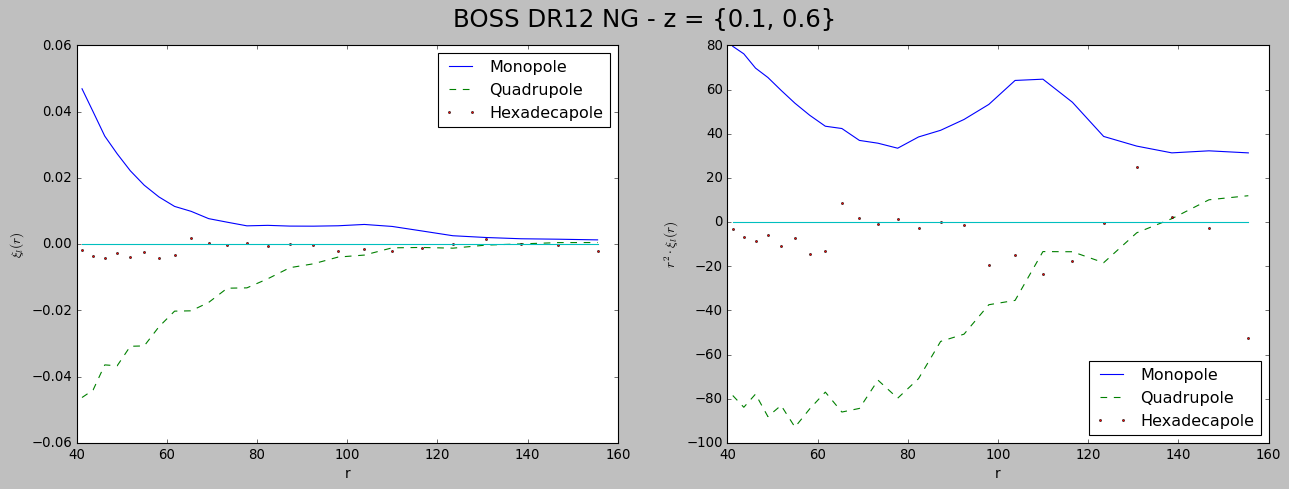

In [56]:
r = binfile
rmin, rmax = 40, 160
x=(r[:-1]+r[1:])/2
mubincenter = (mubin[:-1] + mubin[1:])/2
xi_0, xi_2, xi_4 = cf.multipoles_trapz(mubin, cfunc)

#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')

#first plot
fig=plt.figure(figsize=(16, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 2, left=0.05, right=0.5, wspace=0.05)

ax1 = fig.add_subplot(gs[0,0])
ax1.set_xlim(rmin,rmax)
ax1.plot(x,xi_0,'-',x,xi_2,'--',x,xi_4,'o',markersize=1.9)
ax1.set_xlabel("r")
ax1.set_ylabel(r"$\xi_l(r)$")

ax2 = fig.add_subplot(gs[0,1])
ax2.set_xlim(rmin,rmax)
ax2.plot(x,x**2*xi_0,'-',x,x**2*xi_2,'--',x,x**2*xi_4,'o',markersize=1.9)
ax2.set_xlabel("r")
ax2.set_ylabel(r"$r^2 \cdot \xi_l(r)$")

ax1.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')
ax2.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')

hor = [0]*len(x) 
ax1.plot(x,hor)
ax2.plot(x,hor)

plt.rcParams.update({'font.size': 22})
fig.suptitle('BOSS DR12 NG - z = {' + str(zmin) + ', ' + str(zmax) + '}')

plt.show()

In [45]:
fig.savefig('BOSSDR12_NG-z0106.pdf')

In [44]:
import os